<a href="https://colab.research.google.com/github/nassimhafici/Complete-Python-3-Bootcamp/blob/master/projet_immobilier_web_scrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recherche de Condos sur Centris - web scraping
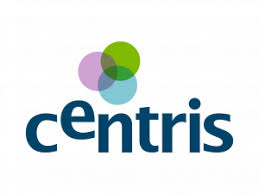
---

> Dernier Update : 2021-03-03

> Auteur: Nassim Hafici, nassim.hafici@gmail.com

### Imports librairies

In [1]:
# BeautifulSoup et autres librairies
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from datetime import datetime
import time
import csv
import pytz
from tqdm import tqdm


# Installer Selenium et les préalables, aucun exécutable à installer préalablement si IDE = Colab
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 911kB 6.8MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1,964 kB]
Hit:14 http://ppa.lau

### Variables Globales


In [2]:
## GLOBAL
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2228.0 Safari/537.36'})
CENTRIS_URL = "https://www.centris.ca/fr/condo~a-vendre~montreal-ile"
REALTOR_URL = "https://www.realtor.ca/map#ZoomLevel=14&Center=45.527634%2C-73.562406&LatitudeMax=45.55063&LongitudeMax=-73.49443&LatitudeMin=45.50463&LongitudeMin=-73.63038&Sort=6-D&PGeoIds=g30_f25dfkk6&GeoName=Montreal%2C%20QC&PropertyTypeGroupID=1&PropertySearchTypeId=3&TransactionTypeId=2&PriceMin=300000&PriceMax=500000&BedRange=2-2&BathRange=1-1&OwnershipTypeGroupId=2&Currency=CAD"
DUPROPRIO_URL = "https://duproprio.com/"

ATTRIBUTES = ('price','is_new','full_address', 'quartier', 'salle_de_bains', 'chambres', 'hyperlink','mls_number')
BIG_LINE = '='*80+'\n'
    

###Fonctions: response et parse html

In [3]:
# FUNCTIONS

def get_response_container(url):
    return requests.get(url, headers = HEADERS)
    
def parse_html(response
               ,keydiv = 'div'
               ,classhtml = 'shell' 
               ,method = 'beautifulsoup'):
  
  if method == 'beautifulsoup':
    response = response.text
  elif method == 'selenium':
    response = response.page_source

  html_soup = BeautifulSoup(response, 'html.parser')

  return html_soup.find_all(keydiv, class_ = classhtml)


### Fonctions: retrouver les attributs des condos

In [4]:

def get_current_page(container):
    current_page =  (container.find_all('div', class_="pager-current")[0]
                  .text
                  .replace(' ','')
                  .split("/")[0])
    return current_page

def get_price(container):
  
  price = (container.find_all('div', class_="price")[0]
                  .text
                  .replace('$','')
                  .replace('\n','')
                  .replace(u'\xa0', '')
                  )
  if '+TPS/TVQ' in price:
    price = price.replace('  +TPS/TVQ','')
    price = round(int(price)*1.15,0)
    is_new = 1
  else:
    price = int(price)
    is_new = 0
  return price, is_new

def get_full_address(container):
    full_address = (container
                    .find_all('span', class_="address")[0]
                    .text)
    return full_address

def get_quartier(container, full_address):
  if 'Quartier' in full_address:
    quartier = (full_address[full_address
                            .find('Quartier')+9:])
  elif '(' in full_address:
    quartier = full_address[full_address.find("(")+1:full_address.find(")")]
  else:
    quartier = full_adress.split(' ')[-1]
  quartier = quartier.replace('\n','')
  return quartier

def get_sdb(container):
  try:
    salle_de_bains = int(container
                        .find_all('div', class_="sdb")[0]
                        .text)
  except:
    salle_de_bains = 0
  return salle_de_bains

def get_chambres(container):
  try:
    chambres = int(container
                .find_all('div', class_="cac")[0]
                .text)
  except:
    chambres = 0
  return chambres

def get_mls_number(container):
  mls_number =   (container
                    .find_all('a', class_="a-more-detail")[1]
                    .text
                    .split('\n'))
  # enlever les cochonneries et empty string pour avoir le 0idx élément
  mls_number = list(filter(None, mls_number))[0] 
  return mls_number

def get_hyperlink(container):
  hyperlink = 'https://www.centris.ca'+container.find_all('a')[0].get('href')
  return hyperlink

### Fonctions: scraper l'information sur chaque page

In [5]:
#-- ATTRIBUTES FROM CONDO --#
def condo_attributes_to_dict(container):
  price, is_new = get_price(container)
  full_address = get_full_address(container)
  quartier = get_quartier(container, full_address)
  salle_de_bains = get_sdb(container)
  chambres = get_chambres(container)
  mls_number = get_mls_number(container)
  hyperlink = get_hyperlink(container)
  #current_page = get_current_page(container)

  attributes_dict = {}
  for i in ATTRIBUTES:
      attributes_dict[i] = locals()[i]

  return attributes_dict

#-- ALL PROPRETIES --#
def scrap_all_propreties(house_containers
                       ,site = 'CENTRIS'
                       ,method = 'beautifulsoup'
                       ,attributes = ATTRIBUTES
                       ,is_info_print = False):

  df_output = pd.DataFrame()
  if house_containers != []: 
    for container in house_containers:
      try:
        dict_out = condo_attributes_to_dict(container)
        df_output = df_output.append(dict_out, ignore_index=True)
      except:
        pass
                        
      #if not int(output_infos['price'].replace(' ','')) > 500000:
      if is_info_print:
        for item in ATTRIBUTES: 
          print(f"{item}: {dict_out[item]}\n")
          print(BIG_LINE)
  return df_output

 
def scrap_real_eastate_propreties(driver):
  """
  Return all informations available for the propreties on the current web page
  and click on the next one.
  """
  WebDriverWait(driver, timeout=5).until(lambda x: x.find_element_by_class_name('address'))
  print('Zizou (ZZzz)\n')
  time.sleep(3)

  house_containers = parse_html(driver, method='selenium')
  df_output = scrap_all_propreties(house_containers)

  driver.find_element_by_class_name('next').click()
  print('\nClick on next page...\n')
  return df_output

def get_current_time(version, geo_zone = 'America/Montreal'):
  timezone = pytz.timezone(geo_zone)
  now = datetime.now(tz=timezone)
  if version == 'FULL':
    return now.strftime("-%Y-%m-%d-%H:%M")
  elif version == 'PARTIAL':
    return now.strftime("%Y-%m-%d")

### Main script -> Exécuter

In [6]:
## ------------------------ MAIN -------------------------------------##
PAGES = 150 # Pour l'instant manuel, on peut aller chercher le nombre de page max, mais la flemme
driver = webdriver.Chrome('chromedriver',options=chrome_options)
driver.get(CENTRIS_URL)

current_time = get_current_time('FULL')
print(f"{2*BIG_LINE}LISTE DES CONDOS AU {current_time} \n{2*BIG_LINE}")

output_lst = []
for page in tqdm(range(PAGES)):
    print(f"Page: {page+1}/{PAGES}")
    output_df = scrap_real_eastate_propreties(driver)
    output_lst.append(output_df)
print('----------------Scraping Done-----------------------\n')


df_final = pd.concat(output_lst)
df_final["date"] = get_current_time('PARTIAL')
df_final.to_csv(f"all_condos{current_time}.csv", index=False ,encoding='utf-8-sig')
print('Fichier .csv enregistré sur le répertoire local courant')

  0%|          | 0/150 [00:00<?, ?it/s]

LISTE DES CONDOS AU -2021-03-09-09:58 

Page: 1/150
Zizou (ZZzz)



  1%|          | 1/150 [00:03<08:19,  3.35s/it]


Click on next page...

Page: 2/150
Zizou (ZZzz)



  1%|▏         | 2/150 [00:06<08:14,  3.34s/it]


Click on next page...

Page: 3/150
Zizou (ZZzz)



  2%|▏         | 3/150 [00:09<08:10,  3.34s/it]


Click on next page...

Page: 4/150
Zizou (ZZzz)



  3%|▎         | 4/150 [00:13<08:06,  3.33s/it]


Click on next page...

Page: 5/150
Zizou (ZZzz)



  3%|▎         | 5/150 [00:16<08:05,  3.35s/it]


Click on next page...

Page: 6/150
Zizou (ZZzz)



  4%|▍         | 6/150 [00:20<08:00,  3.34s/it]


Click on next page...

Page: 7/150
Zizou (ZZzz)



  5%|▍         | 7/150 [00:23<07:57,  3.34s/it]


Click on next page...

Page: 8/150
Zizou (ZZzz)



  5%|▌         | 8/150 [00:26<07:52,  3.33s/it]


Click on next page...

Page: 9/150
Zizou (ZZzz)



  6%|▌         | 9/150 [00:29<07:48,  3.32s/it]


Click on next page...

Page: 10/150
Zizou (ZZzz)



  7%|▋         | 10/150 [00:33<07:48,  3.35s/it]


Click on next page...

Page: 11/150
Zizou (ZZzz)



  7%|▋         | 11/150 [00:36<07:44,  3.34s/it]


Click on next page...

Page: 12/150
Zizou (ZZzz)



  8%|▊         | 12/150 [00:40<07:39,  3.33s/it]


Click on next page...

Page: 13/150
Zizou (ZZzz)



  9%|▊         | 13/150 [00:43<07:35,  3.32s/it]


Click on next page...

Page: 14/150
Zizou (ZZzz)



  9%|▉         | 14/150 [00:46<07:31,  3.32s/it]


Click on next page...

Page: 15/150
Zizou (ZZzz)



 10%|█         | 15/150 [00:50<07:31,  3.34s/it]


Click on next page...

Page: 16/150
Zizou (ZZzz)



 11%|█         | 16/150 [00:53<07:26,  3.33s/it]


Click on next page...

Page: 17/150
Zizou (ZZzz)



 11%|█▏        | 17/150 [00:56<07:22,  3.32s/it]


Click on next page...

Page: 18/150
Zizou (ZZzz)



 12%|█▏        | 18/150 [00:59<07:17,  3.32s/it]


Click on next page...

Page: 19/150
Zizou (ZZzz)



 13%|█▎        | 19/150 [01:03<07:14,  3.31s/it]


Click on next page...

Page: 20/150
Zizou (ZZzz)



 13%|█▎        | 20/150 [01:06<07:13,  3.34s/it]


Click on next page...

Page: 21/150
Zizou (ZZzz)



 14%|█▍        | 21/150 [01:09<07:11,  3.34s/it]


Click on next page...

Page: 22/150
Zizou (ZZzz)



 15%|█▍        | 22/150 [01:13<07:06,  3.33s/it]


Click on next page...

Page: 23/150
Zizou (ZZzz)



 15%|█▌        | 23/150 [01:16<07:01,  3.32s/it]


Click on next page...

Page: 24/150
Zizou (ZZzz)



 16%|█▌        | 24/150 [01:19<06:58,  3.32s/it]


Click on next page...

Page: 25/150
Zizou (ZZzz)



 17%|█▋        | 25/150 [01:23<06:54,  3.32s/it]


Click on next page...

Page: 26/150
Zizou (ZZzz)



 17%|█▋        | 26/150 [01:26<06:54,  3.34s/it]


Click on next page...

Page: 27/150
Zizou (ZZzz)



 18%|█▊        | 27/150 [01:29<06:49,  3.33s/it]


Click on next page...

Page: 28/150
Zizou (ZZzz)



 19%|█▊        | 28/150 [01:33<06:45,  3.32s/it]


Click on next page...

Page: 29/150
Zizou (ZZzz)



 19%|█▉        | 29/150 [01:36<06:40,  3.31s/it]


Click on next page...

Page: 30/150
Zizou (ZZzz)



 20%|██        | 30/150 [01:39<06:36,  3.31s/it]


Click on next page...

Page: 31/150
Zizou (ZZzz)



 21%|██        | 31/150 [01:43<06:36,  3.33s/it]


Click on next page...

Page: 32/150
Zizou (ZZzz)



 21%|██▏       | 32/150 [01:46<06:31,  3.32s/it]


Click on next page...

Page: 33/150
Zizou (ZZzz)



 22%|██▏       | 33/150 [01:49<06:28,  3.32s/it]


Click on next page...

Page: 34/150
Zizou (ZZzz)



 23%|██▎       | 34/150 [01:53<06:24,  3.32s/it]


Click on next page...

Page: 35/150
Zizou (ZZzz)



 23%|██▎       | 35/150 [01:56<06:21,  3.31s/it]


Click on next page...

Page: 36/150
Zizou (ZZzz)



 24%|██▍       | 36/150 [01:59<06:21,  3.34s/it]


Click on next page...

Page: 37/150
Zizou (ZZzz)



 25%|██▍       | 37/150 [02:03<06:16,  3.33s/it]


Click on next page...

Page: 38/150
Zizou (ZZzz)



 25%|██▌       | 38/150 [02:06<06:11,  3.32s/it]


Click on next page...

Page: 39/150
Zizou (ZZzz)



 26%|██▌       | 39/150 [02:09<06:07,  3.31s/it]


Click on next page...

Page: 40/150
Zizou (ZZzz)



 27%|██▋       | 40/150 [02:13<06:04,  3.31s/it]


Click on next page...

Page: 41/150
Zizou (ZZzz)



 27%|██▋       | 41/150 [02:16<06:03,  3.33s/it]


Click on next page...

Page: 42/150
Zizou (ZZzz)



 28%|██▊       | 42/150 [02:19<05:58,  3.32s/it]


Click on next page...

Page: 43/150
Zizou (ZZzz)



 29%|██▊       | 43/150 [02:23<05:55,  3.32s/it]


Click on next page...

Page: 44/150
Zizou (ZZzz)



 29%|██▉       | 44/150 [02:26<05:51,  3.31s/it]


Click on next page...

Page: 45/150
Zizou (ZZzz)



 30%|███       | 45/150 [02:29<05:47,  3.31s/it]


Click on next page...

Page: 46/150
Zizou (ZZzz)



 31%|███       | 46/150 [02:32<05:43,  3.31s/it]


Click on next page...

Page: 47/150
Zizou (ZZzz)



 31%|███▏      | 47/150 [02:36<05:43,  3.33s/it]


Click on next page...

Page: 48/150
Zizou (ZZzz)



 32%|███▏      | 48/150 [02:39<05:39,  3.33s/it]


Click on next page...

Page: 49/150
Zizou (ZZzz)



 33%|███▎      | 49/150 [02:42<05:34,  3.32s/it]


Click on next page...

Page: 50/150
Zizou (ZZzz)



 33%|███▎      | 50/150 [02:46<05:31,  3.32s/it]


Click on next page...

Page: 51/150
Zizou (ZZzz)



 34%|███▍      | 51/150 [02:49<05:28,  3.32s/it]


Click on next page...

Page: 52/150
Zizou (ZZzz)



 35%|███▍      | 52/150 [02:52<05:26,  3.34s/it]


Click on next page...

Page: 53/150
Zizou (ZZzz)



 35%|███▌      | 53/150 [02:56<05:22,  3.32s/it]


Click on next page...

Page: 54/150
Zizou (ZZzz)



 36%|███▌      | 54/150 [02:59<05:18,  3.32s/it]


Click on next page...

Page: 55/150
Zizou (ZZzz)



 37%|███▋      | 55/150 [03:02<05:15,  3.32s/it]


Click on next page...

Page: 56/150
Zizou (ZZzz)



 37%|███▋      | 56/150 [03:06<05:11,  3.31s/it]


Click on next page...

Page: 57/150
Zizou (ZZzz)



 38%|███▊      | 57/150 [03:09<05:10,  3.34s/it]


Click on next page...

Page: 58/150
Zizou (ZZzz)



 39%|███▊      | 58/150 [03:12<05:06,  3.33s/it]


Click on next page...

Page: 59/150
Zizou (ZZzz)



 39%|███▉      | 59/150 [03:16<05:02,  3.32s/it]


Click on next page...

Page: 60/150
Zizou (ZZzz)



 40%|████      | 60/150 [03:19<04:58,  3.32s/it]


Click on next page...

Page: 61/150
Zizou (ZZzz)



 41%|████      | 61/150 [03:22<04:54,  3.31s/it]


Click on next page...

Page: 62/150
Zizou (ZZzz)



 41%|████▏     | 62/150 [03:26<04:53,  3.33s/it]


Click on next page...

Page: 63/150
Zizou (ZZzz)



 42%|████▏     | 63/150 [03:29<04:49,  3.33s/it]


Click on next page...

Page: 64/150
Zizou (ZZzz)



 43%|████▎     | 64/150 [03:32<04:46,  3.33s/it]


Click on next page...

Page: 65/150
Zizou (ZZzz)



 43%|████▎     | 65/150 [03:36<04:42,  3.32s/it]


Click on next page...

Page: 66/150
Zizou (ZZzz)



 44%|████▍     | 66/150 [03:39<04:38,  3.32s/it]


Click on next page...

Page: 67/150
Zizou (ZZzz)



 45%|████▍     | 67/150 [03:42<04:37,  3.34s/it]


Click on next page...

Page: 68/150
Zizou (ZZzz)



 45%|████▌     | 68/150 [03:46<04:33,  3.33s/it]


Click on next page...

Page: 69/150
Zizou (ZZzz)



 46%|████▌     | 69/150 [03:49<04:29,  3.32s/it]


Click on next page...

Page: 70/150
Zizou (ZZzz)



 47%|████▋     | 70/150 [03:52<04:25,  3.32s/it]


Click on next page...

Page: 71/150
Zizou (ZZzz)



 47%|████▋     | 71/150 [03:56<04:21,  3.32s/it]


Click on next page...

Page: 72/150
Zizou (ZZzz)



 48%|████▊     | 72/150 [03:59<04:18,  3.32s/it]


Click on next page...

Page: 73/150
Zizou (ZZzz)



 49%|████▊     | 73/150 [04:02<04:17,  3.34s/it]


Click on next page...

Page: 74/150
Zizou (ZZzz)



 49%|████▉     | 74/150 [04:06<04:13,  3.33s/it]


Click on next page...

Page: 75/150
Zizou (ZZzz)



 50%|█████     | 75/150 [04:09<04:09,  3.32s/it]


Click on next page...

Page: 76/150
Zizou (ZZzz)



 51%|█████     | 76/150 [04:12<04:05,  3.32s/it]


Click on next page...

Page: 77/150
Zizou (ZZzz)



 51%|█████▏    | 77/150 [04:15<04:02,  3.32s/it]


Click on next page...

Page: 78/150
Zizou (ZZzz)



 52%|█████▏    | 78/150 [04:19<04:00,  3.34s/it]


Click on next page...

Page: 79/150
Zizou (ZZzz)



 53%|█████▎    | 79/150 [04:22<03:56,  3.33s/it]


Click on next page...

Page: 80/150
Zizou (ZZzz)



 53%|█████▎    | 80/150 [04:25<03:52,  3.32s/it]


Click on next page...

Page: 81/150
Zizou (ZZzz)



 54%|█████▍    | 81/150 [04:29<03:48,  3.31s/it]


Click on next page...

Page: 82/150
Zizou (ZZzz)



 55%|█████▍    | 82/150 [04:32<03:44,  3.31s/it]


Click on next page...

Page: 83/150
Zizou (ZZzz)



 55%|█████▌    | 83/150 [04:35<03:43,  3.34s/it]


Click on next page...

Page: 84/150
Zizou (ZZzz)



 56%|█████▌    | 84/150 [04:39<03:39,  3.32s/it]


Click on next page...

Page: 85/150
Zizou (ZZzz)



 57%|█████▋    | 85/150 [04:42<03:35,  3.32s/it]


Click on next page...

Page: 86/150
Zizou (ZZzz)



 57%|█████▋    | 86/150 [04:45<03:32,  3.33s/it]


Click on next page...

Page: 87/150
Zizou (ZZzz)



 58%|█████▊    | 87/150 [04:49<03:29,  3.32s/it]


Click on next page...

Page: 88/150
Zizou (ZZzz)



 59%|█████▊    | 88/150 [04:52<03:27,  3.34s/it]


Click on next page...

Page: 89/150
Zizou (ZZzz)



 59%|█████▉    | 89/150 [04:55<03:23,  3.33s/it]


Click on next page...

Page: 90/150
Zizou (ZZzz)



 60%|██████    | 90/150 [04:59<03:19,  3.32s/it]


Click on next page...

Page: 91/150
Zizou (ZZzz)



 61%|██████    | 91/150 [05:02<03:15,  3.31s/it]


Click on next page...

Page: 92/150
Zizou (ZZzz)



 61%|██████▏   | 92/150 [05:05<03:11,  3.31s/it]


Click on next page...

Page: 93/150
Zizou (ZZzz)



 62%|██████▏   | 93/150 [05:09<03:09,  3.32s/it]


Click on next page...

Page: 94/150
Zizou (ZZzz)



 63%|██████▎   | 94/150 [05:12<03:07,  3.35s/it]


Click on next page...

Page: 95/150
Zizou (ZZzz)



 63%|██████▎   | 95/150 [05:15<03:03,  3.33s/it]


Click on next page...

Page: 96/150
Zizou (ZZzz)



 64%|██████▍   | 96/150 [05:19<02:59,  3.33s/it]


Click on next page...

Page: 97/150
Zizou (ZZzz)



 65%|██████▍   | 97/150 [05:22<02:56,  3.32s/it]


Click on next page...

Page: 98/150
Zizou (ZZzz)



 65%|██████▌   | 98/150 [05:25<02:53,  3.33s/it]


Click on next page...

Page: 99/150
Zizou (ZZzz)



 66%|██████▌   | 99/150 [05:29<02:50,  3.35s/it]


Click on next page...

Page: 100/150
Zizou (ZZzz)



 67%|██████▋   | 100/150 [05:32<02:46,  3.33s/it]


Click on next page...

Page: 101/150
Zizou (ZZzz)



 67%|██████▋   | 101/150 [05:35<02:43,  3.34s/it]


Click on next page...

Page: 102/150
Zizou (ZZzz)



 68%|██████▊   | 102/150 [05:39<02:40,  3.33s/it]


Click on next page...

Page: 103/150
Zizou (ZZzz)



 69%|██████▊   | 103/150 [05:42<02:36,  3.32s/it]


Click on next page...

Page: 104/150
Zizou (ZZzz)



 69%|██████▉   | 104/150 [05:45<02:33,  3.35s/it]


Click on next page...

Page: 105/150
Zizou (ZZzz)



 70%|███████   | 105/150 [05:49<02:29,  3.33s/it]


Click on next page...

Page: 106/150
Zizou (ZZzz)



 71%|███████   | 106/150 [05:52<02:26,  3.33s/it]


Click on next page...

Page: 107/150
Zizou (ZZzz)



 71%|███████▏  | 107/150 [05:55<02:22,  3.32s/it]


Click on next page...

Page: 108/150
Zizou (ZZzz)



 72%|███████▏  | 108/150 [05:59<02:19,  3.32s/it]


Click on next page...

Page: 109/150
Zizou (ZZzz)



 73%|███████▎  | 109/150 [06:02<02:17,  3.35s/it]


Click on next page...

Page: 110/150
Zizou (ZZzz)



 73%|███████▎  | 110/150 [06:05<02:13,  3.34s/it]


Click on next page...

Page: 111/150
Zizou (ZZzz)



 74%|███████▍  | 111/150 [06:09<02:09,  3.33s/it]


Click on next page...

Page: 112/150
Zizou (ZZzz)



 75%|███████▍  | 112/150 [06:12<02:06,  3.32s/it]


Click on next page...

Page: 113/150
Zizou (ZZzz)



 75%|███████▌  | 113/150 [06:15<02:02,  3.31s/it]


Click on next page...

Page: 114/150
Zizou (ZZzz)



 76%|███████▌  | 114/150 [06:19<01:59,  3.31s/it]


Click on next page...

Page: 115/150
Zizou (ZZzz)



 77%|███████▋  | 115/150 [06:22<01:56,  3.33s/it]


Click on next page...

Page: 116/150
Zizou (ZZzz)



 77%|███████▋  | 116/150 [06:25<01:53,  3.33s/it]


Click on next page...

Page: 117/150
Zizou (ZZzz)



 78%|███████▊  | 117/150 [06:29<01:49,  3.32s/it]


Click on next page...

Page: 118/150
Zizou (ZZzz)



 79%|███████▊  | 118/150 [06:32<01:46,  3.32s/it]


Click on next page...

Page: 119/150
Zizou (ZZzz)



 79%|███████▉  | 119/150 [06:35<01:42,  3.32s/it]


Click on next page...

Page: 120/150
Zizou (ZZzz)



 80%|████████  | 120/150 [06:39<01:40,  3.34s/it]


Click on next page...

Page: 121/150
Zizou (ZZzz)



 81%|████████  | 121/150 [06:42<01:36,  3.33s/it]


Click on next page...

Page: 122/150
Zizou (ZZzz)



 81%|████████▏ | 122/150 [06:45<01:33,  3.32s/it]


Click on next page...

Page: 123/150
Zizou (ZZzz)



 82%|████████▏ | 123/150 [06:49<01:29,  3.33s/it]


Click on next page...

Page: 124/150
Zizou (ZZzz)



 83%|████████▎ | 124/150 [06:52<01:26,  3.32s/it]


Click on next page...

Page: 125/150
Zizou (ZZzz)



 83%|████████▎ | 125/150 [06:55<01:23,  3.34s/it]


Click on next page...

Page: 126/150
Zizou (ZZzz)



 84%|████████▍ | 126/150 [06:59<01:19,  3.33s/it]


Click on next page...

Page: 127/150
Zizou (ZZzz)



 85%|████████▍ | 127/150 [07:02<01:16,  3.32s/it]


Click on next page...

Page: 128/150
Zizou (ZZzz)



 85%|████████▌ | 128/150 [07:05<01:12,  3.31s/it]


Click on next page...

Page: 129/150
Zizou (ZZzz)



 86%|████████▌ | 129/150 [07:08<01:09,  3.31s/it]


Click on next page...

Page: 130/150
Zizou (ZZzz)



 87%|████████▋ | 130/150 [07:12<01:06,  3.33s/it]


Click on next page...

Page: 131/150
Zizou (ZZzz)



 87%|████████▋ | 131/150 [07:15<01:03,  3.32s/it]


Click on next page...

Page: 132/150
Zizou (ZZzz)



 88%|████████▊ | 132/150 [07:18<00:59,  3.32s/it]


Click on next page...

Page: 133/150
Zizou (ZZzz)



 89%|████████▊ | 133/150 [07:22<00:56,  3.31s/it]


Click on next page...

Page: 134/150
Zizou (ZZzz)



 89%|████████▉ | 134/150 [07:25<00:52,  3.31s/it]


Click on next page...

Page: 135/150
Zizou (ZZzz)



 90%|█████████ | 135/150 [07:28<00:49,  3.33s/it]


Click on next page...

Page: 136/150
Zizou (ZZzz)



 91%|█████████ | 136/150 [07:32<00:46,  3.35s/it]


Click on next page...

Page: 137/150
Zizou (ZZzz)



 91%|█████████▏| 137/150 [07:35<00:43,  3.34s/it]


Click on next page...

Page: 138/150
Zizou (ZZzz)



 92%|█████████▏| 138/150 [07:38<00:40,  3.34s/it]


Click on next page...

Page: 139/150
Zizou (ZZzz)



 93%|█████████▎| 139/150 [07:42<00:36,  3.33s/it]


Click on next page...

Page: 140/150
Zizou (ZZzz)



 93%|█████████▎| 140/150 [07:45<00:33,  3.32s/it]


Click on next page...

Page: 141/150
Zizou (ZZzz)



 94%|█████████▍| 141/150 [07:48<00:30,  3.34s/it]


Click on next page...

Page: 142/150
Zizou (ZZzz)



 95%|█████████▍| 142/150 [07:52<00:26,  3.33s/it]


Click on next page...

Page: 143/150
Zizou (ZZzz)



 95%|█████████▌| 143/150 [07:55<00:23,  3.32s/it]


Click on next page...

Page: 144/150
Zizou (ZZzz)



 96%|█████████▌| 144/150 [07:58<00:19,  3.32s/it]


Click on next page...

Page: 145/150
Zizou (ZZzz)



 97%|█████████▋| 145/150 [08:02<00:16,  3.32s/it]


Click on next page...

Page: 146/150
Zizou (ZZzz)



 97%|█████████▋| 146/150 [08:05<00:13,  3.34s/it]


Click on next page...

Page: 147/150
Zizou (ZZzz)



 98%|█████████▊| 147/150 [08:08<00:10,  3.34s/it]


Click on next page...

Page: 148/150
Zizou (ZZzz)



 99%|█████████▊| 148/150 [08:12<00:06,  3.33s/it]


Click on next page...

Page: 149/150
Zizou (ZZzz)



 99%|█████████▉| 149/150 [08:15<00:03,  3.32s/it]


Click on next page...

Page: 150/150
Zizou (ZZzz)



100%|██████████| 150/150 [08:18<00:00,  3.33s/it]


Click on next page...

----------------Scraping Done-----------------------



Fichier .csv enregistré sur le répertoire local courant


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt




price
quartier                     chambres           
Hochelaga-Maisonneuve        1.0        281635.0
                             2.0        370000.0
                             3.0        512450.0
La Petite-Patrie             1.0        380000.0
                             2.0        489000.0
                             3.0        699900.0
Le Plateau-Mont-Royal        1.0        363000.0
                             2.0        549000.0
                             3.0        699000.0
Mile-End                     1.0        382000.0
                             2.0        684000.0
                             3.0        739000.0
Petite Italie                1.0        384000.0
                             2.0        495000.0
                             3.0       1548000.0
Saint-Henri/Petite Bourgogne 1.0        350000.0
                             2.0        525000.0
                             3.0        869000.0
Shop Angus                   1.0        349000.0
                             2.0        449450.0
                             3.0        792836.5
Verdun                       1.0        314000.0
                             2.0        399000.0
                             3.0        549000.0
Villeray                     1.0        449000.0
                             2.0        505000.0
                             3.0        937657.0

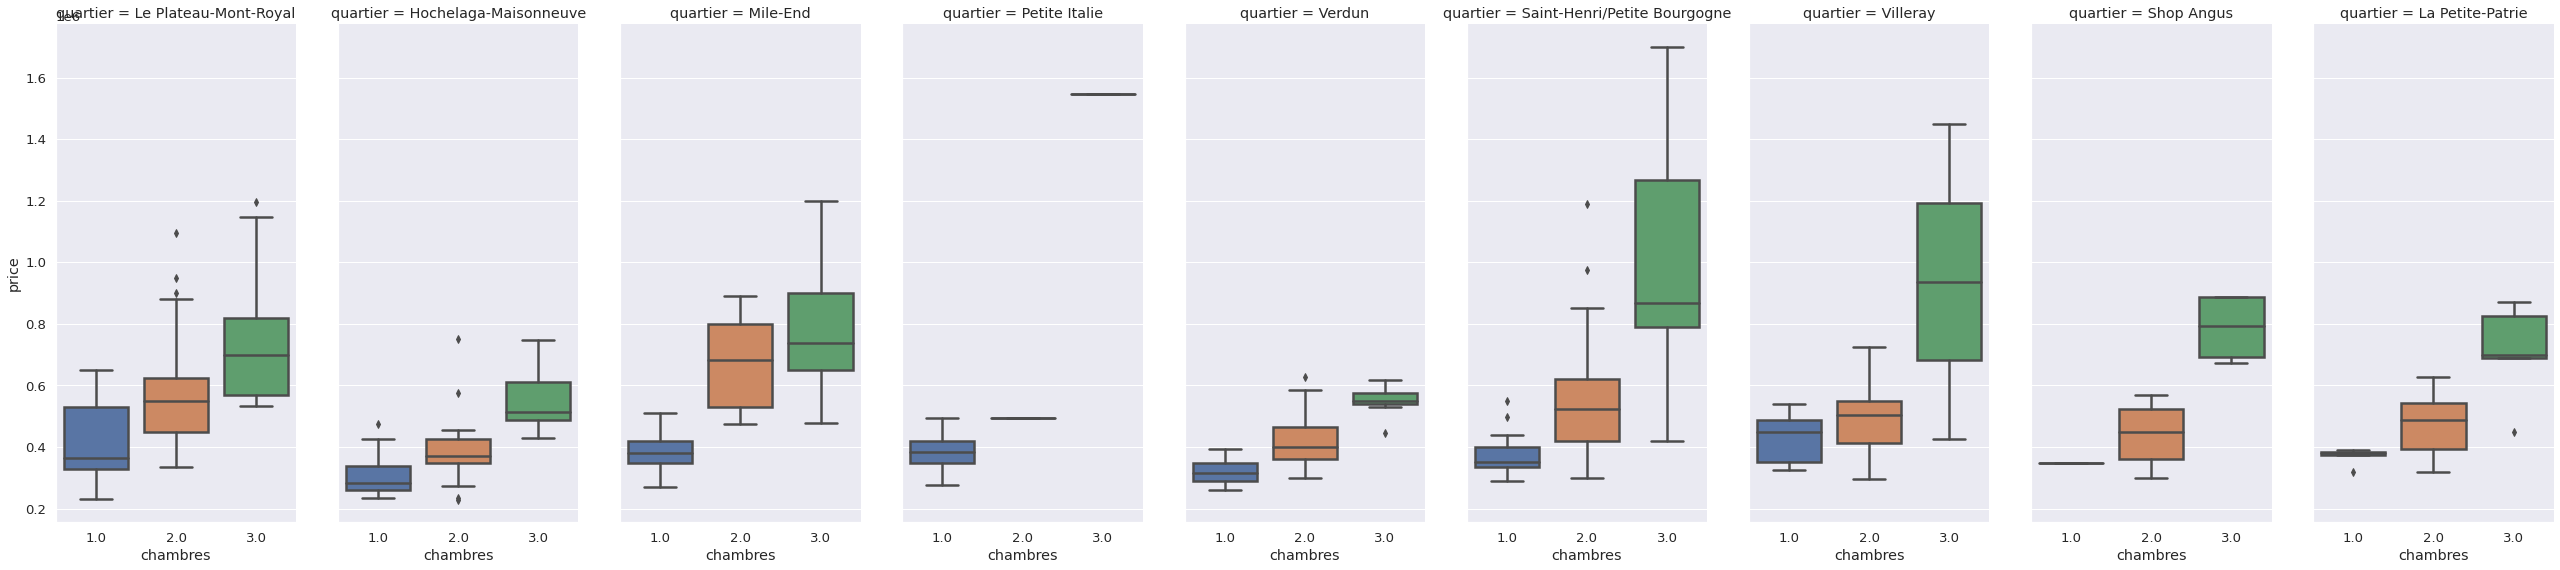

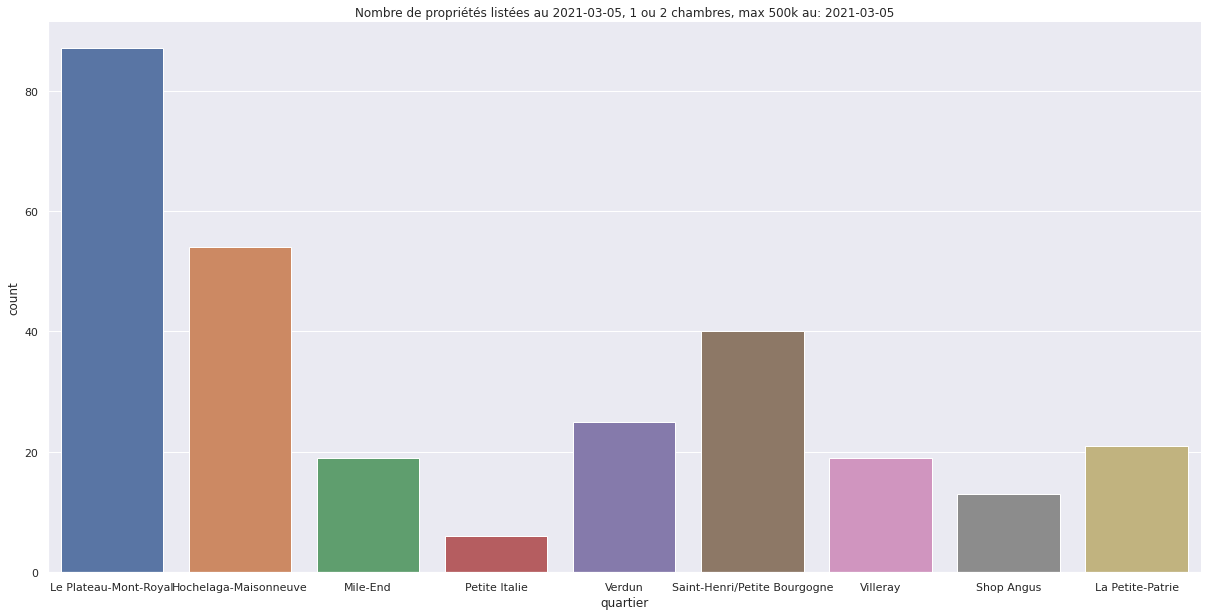

In [ ]:
# params vis
date = get_current_time('PARTIAL')
PRIX_MAX = 6e6
N_MAX_ROOM = 4
N_MIN_ROOM = 2
QUARTIERS = ['Le Plateau-Mont-Royal','Hochelaga-Maisonneuve','Saint-Henri/Petite Bourgogne','Verdun','Shop Angus','Villeray','La Petite-Patrie','Petite Italie','Mile-End']
QUARTIERS = sorted(QUARTIERS)

df_cut = df_final[(df_final["chambres"] <= N_MAX_ROOM) & (df_final["chambres"] >N_MIN_ROOM)]
df_cut = df_cut[(df_cut["price"] <= PRIX_MAX)]
df_cut = df_cut[df_cut['quartier'].isin(QUARTIERS)]

# Graphiques
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
g_box = sns.catplot(x="chambres", y="price",
                 col="quartier",
                data=df_cut, kind="box",
                height=7.9, aspect=0.5)



sns.set(rc={'figure.figsize':(140,8.27)})


g_count = sns.catplot(x='quartier'
          ,data=df_cut
          ,kind='count'
          ,height=8.27, aspect=16.7/8.27).set(title=f"Nombre de propriétés listées au 2021-03-05, 1 ou 2 chambres, max 500k au: {date}")

df_grouped = df_cut[['quartier', 'price', 'chambres']]
df_grouped.groupby(['quartier','chambres']).median()




In [ ]:
df_final['quartier'].unique()